In [114]:
%matplotlib widget
import matplotlib.pyplot as plt

import torch

import efield

from importlib import reload

In [ ]:
import numpy as np

x = np.random.randn(3)
x1 = np.random.randn(3)
x2 = np.random.randn(3)
print(
    np.linalg.norm(x - x1) ** 2 + np.linalg.norm(x - x2) ** 2,
    2 * np.linalg.norm(x - (x1 + x2) / 2) ** 2 + 0.5 * np.linalg.norm(x1 - x2) ** 2,
)

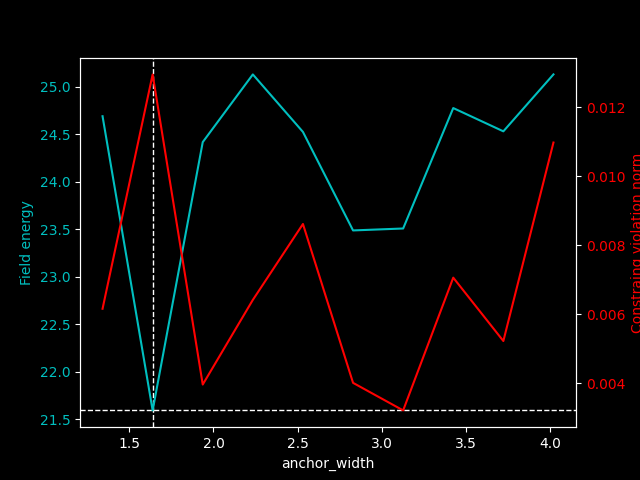

In [147]:
reload(efield)


def parallel_plates(plate1: efield.Box, plate2: efield.Box, universe: efield.Box):
    electrode1_locations3d = plate1.grid(10, 10, 2)
    electrode2_locations3d = plate2.grid(10, 10, 2)

    conductor_locations3d = torch.vstack(
        (electrode1_locations3d, electrode2_locations3d)
    )

    conductor_potentials = torch.tensor(
        [-1] * len(electrode1_locations3d) + [1] * len(electrode2_locations3d),
        dtype=torch.float32,
    )

    test_locations3d = torch.vstack((universe.grid(10, 10, 10), conductor_locations3d))

    potential = efield.potential_function(
        test_locations3d, conductor_locations3d, conductor_potentials
    )

    return potential


plate1 = efield.Box(-1, +1, -1, +1, -1.1, -1.0)
plate2 = efield.Box(-1, +1, -1, +1, +1.0, +1.1)
universe = efield.Box(
    min(plate1.xmin, plate2.xmin) - 1,
    max(plate1.xmax, plate2.xmax) + 1,
    min(plate1.ymin, plate2.ymin) - 1,
    max(plate1.ymax, plate2.ymax) + 1,
    min(plate1.zmin, plate2.zmin) - 1,
    max(plate1.zmax, plate2.zmax) + 1,
)
potential = parallel_plates(plate1, plate2, universe)

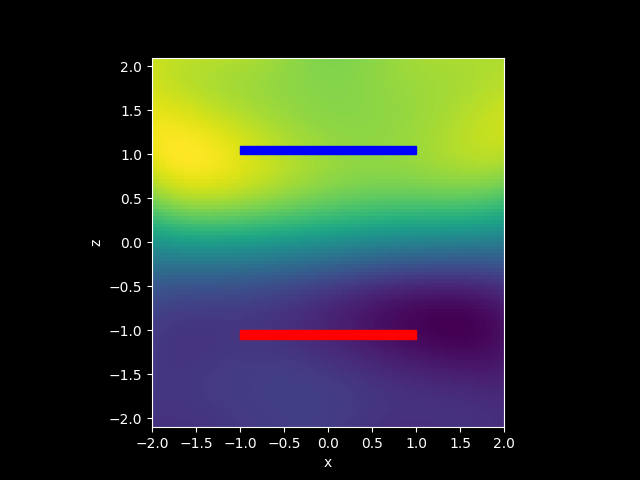

In [148]:
def show_xz_cross_section(
    plate1: efield.Box,
    plate2: efield.Box,
    universe: efield.Box,
    potential: efield.Potential,
    y: float,
):
    X, Z = torch.meshgrid(
        torch.linspace(universe.xmin, universe.xmax, 100),
        torch.linspace(universe.zmin, universe.zmax, 100),
        indexing="xy",
    )
    xyz = torch.stack((X.flatten(), X.flatten() * 0 + y, Z.flatten())).T

    V = potential(xyz).reshape(X.shape).detach().numpy()

    _, ax = plt.subplots(1, 1)
    ax.imshow(
        V,
        extent=(universe.xmin, universe.xmax, universe.zmin, universe.zmax),
        origin="lower",
    )
    ax.add_artist(
        plt.Rectangle(
            (plate1.xmin, plate1.zmin),
            plate1.xmax - plate1.xmin,
            plate1.zmax - plate1.zmin,
            color="r",
        )
    )
    ax.add_artist(
        plt.Rectangle(
            (plate2.xmin, plate2.zmin),
            plate2.xmax - plate2.xmin,
            plate2.zmax - plate2.zmin,
            color="b",
        ),
    )
    ax.set_xlabel("x")
    ax.set_ylabel("z")


show_xz_cross_section(plate1, plate2, universe, potential, 0)

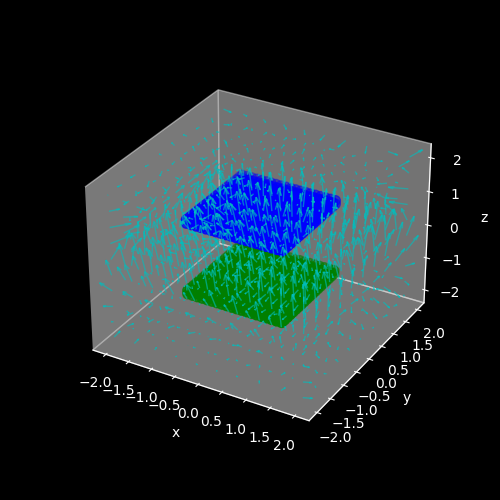

In [149]:
def show_field(
    plate1: efield.Box,
    plate2: efield.Box,
    universe: efield.Box,
    potential: efield.Potential,
):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")

    plate1_locations3d = plate1.grid(20, 20, 2)
    ax.scatter(
        plate1_locations3d[:, 0],
        plate1_locations3d[:, 1],
        plate1_locations3d[:, 2],
        s=50,
        color="g",
    )
    plate2_locations3d = plate2.grid(20, 20, 2)
    ax.scatter(
        plate2_locations3d[:, 0],
        plate2_locations3d[:, 1],
        plate2_locations3d[:, 2],
        s=50,
        color="b",
    )
    xyz = universe.grid(10, 10, 10)

    Vx, Vy, Vz = potential.field(xyz).detach()
    ax.quiver(
        xyz[:, 0],
        xyz[:, 1],
        xyz[:, 2],
        Vx,
        Vy,
        Vz,
        lw=1,
        alpha=0.6,
        length=0.5,
        color="c",
    )
    ax.grid(False)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


show_field(plate1, plate2, universe, potential)